# Init

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [8]:
kb = 3.1668105e-06 # in hartree
ha2ev = 27.211386
kbev = kb*ha2ev # in eV
T0=100
natombcc=250
natomvacancy=250-1
nfreebcc=(natombcc-1)*3
nfreevacancy=(natomvacancy-1)*3

## The energy units in this notebook is in eV, unless specified otherwise

# 0K results

In [9]:
U0bcc=-1030.60877518368
U0vacancy=-1024.77431283251

# The free energy of the reference harmonic system with fixed center of mass at 100K
### $A_\text{h}(T_0)=k_B T_0\sum_{i=1}^{3N-3}\ln(\dfrac{\hbar \omega_i}{k_B T_0})$

In [10]:
eva = np.loadtxt("ipi-100K/bcc-phonon/perfect-fd.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmbccT0 = ha2ev*T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()
print AharmbccT0

6.94539173078


In [11]:
eva = np.loadtxt("ipi-100K/vacancy-phonon/vacancy-fd.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmvacancyT0 = ha2ev*T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()
print AharmvacancyT0

6.89595727377


# Anharmonic correction of A at 100K
### $A(T_0) = A_\text{h}(T_0)+U(0) - k_B T_0 \ln\left<\exp\left[\dfrac{-(U - U_\text{h}-U(0))}{k_B T_0}\right]\right>_{V,T_0,\lambda=0}$
now we first compute $A_{anh}=- k_B T_0 \ln\left<\exp\left[\dfrac{-(U - U_\text{h}-U(0))}{k_B T_0}\right]\right>_{V,T_0,\lambda=0}$

In [12]:
anhdata=np.loadtxt("ipi-100K/bcc-har/perfect.out")[100:,5:7] # the ipi outputs are in the unit of hartree
autocorrtime=2 # autocorrelation time in the units of stride 
mean=np.exp(-(anhdata[:,1]-anhdata[:,0]-U0bcc/ha2ev)/(T0*kb)).mean()
error=np.sqrt(autocorrtime)*stats.sem(np.exp(-(anhdata[:,1]-anhdata[:,0]-U0bcc/ha2ev)/(T0*kb)), axis=None, ddof=0)
#print mean, error
AanhbccT0=-ha2ev*T0*kb*np.log(mean)
AanhbccT0error=ha2ev*T0*kb*(np.log(mean+error)-np.log(mean-error))/2.
AbccT0=AharmbccT0+U0bcc+AanhbccT0
print AharmbccT0, U0bcc, AanhbccT0
print AbccT0, "+/-", AanhbccT0error

6.94539173078 -1030.60877518 -0.0614964069974
-1023.72487986 +/- 0.000234864092527


In [13]:
anhdata=np.loadtxt("ipi-100K/vacancy-har/vacancy.out")[100:,5:7] # the ipi outputs are in the unit of hartree
mean=np.exp(-(anhdata[:,1]-anhdata[:,0]-U0vacancy/ha2ev)/(T0*kb)).mean()
error=np.sqrt(autocorrtime)*stats.sem(np.exp(-(anhdata[:,1]-anhdata[:,0]-U0vacancy/ha2ev)/(T0*kb)), axis=None, ddof=0)
#print mean, error
AanhvacancyT0=-ha2ev*T0*kb*np.log(mean)
AanhvacancyT0error=-ha2ev*T0*kb*(np.log(mean+error)-np.log(mean-error))/2.
AvacancyT0=AharmvacancyT0+U0vacancy+AanhvacancyT0
print AharmvacancyT0, U0vacancy, AanhvacancyT0
print AvacancyT0, "+/-", AanhvacancyT0error

6.89595727377 -1024.77431283 -0.0640415889703
-1017.94239715 +/- -0.000169030817626


# Transform the Helmholtz free energy to the Gibbs free energy
#### We used the isothermal-isobaric ensemble (NPT) in the simulations with zero external pressure, and allowed the 3 dimensions of the orthorhombic simulation cell are allowed to fluctuate independently. In this case we have
#### $G(P,T) = A (\textbf{h},T) + P \text{det}(\textbf{h}) + k_B T \ln \rho(\textbf{h}|P,T)$.
#### As $P=0$ in our case, so here we only need to compute $k_B T \ln \rho(\textbf{h}|P,T)$
#### For convinience, we used a bash script (processrhoxyz.sh) to compute this quantity.

In [14]:
A2GbccT0=[0.0908702, 0.00071327]
A2GvacancyT0=[0.0903102, 0.000948099]

GbccT0=AbccT0+A2GbccT0[0]
GbccT0error=AanhbccT0error+A2GbccT0[1]
print "Gbcc100K:",GbccT0, "+/-", GbccT0error

GvacancyT0=AvacancyT0+A2GvacancyT0[0]
GvacancyT0error=AanhvacancyT0error+A2GvacancyT0[1]
print "Gvacancy 100K:",GvacancyT0, "+/-", GvacancyT0error


Gbcc100K: -1023.63400966 +/- 0.000948134092527
Gvacancy 100K: -1017.85208695 +/- 0.000779068182374


# Thermodynamic Intergation at NPT
### $-T_1\int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{ T^2} dT=-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$,

### In our case P=0 so $H=U$.

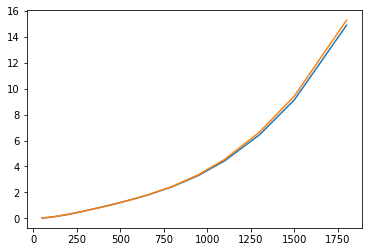

In [15]:
ttnpt = np.asarray([50, 60, 70, 85, 100, 120, 140, 170, 200, 240, 280, 340, 400, 480, 560, 660, 800, 950, 1100, 1300, 1500, 1800])
ltnpt = np.log(ttnpt)
dhbcc = ttnpt*0.0
dhbccerror = ttnpt*0.0
dhvacancy = ttnpt*0.0
dhvacancyerror = ttnpt*0.0

dhbcc = np.loadtxt("lammps-npt/bcc-PE.list")[:,1]
dhbccerror = np.loadtxt("lammps-npt/bcc-PE.list")[:,2]
for a in xrange(len(ttnpt)):
    dhbcc[a] += -U0bcc- ttnpt[a]*kbev*nfreebcc/2.

dhvacancy = np.loadtxt("lammps-npt/vacancy-PE.list")[:,1]
dhvacancyerror = np.loadtxt("lammps-npt/vacancy-PE.list")[:,2]
for a in xrange(len(ttnpt)):
    dhvacancy[a] += -U0vacancy- ttnpt[a]*kbev*nfreevacancy/2.

plt.plot(ttnpt,dhbcc)
plt.plot(ttnpt,dhvacancy)
plt.show()

#### TI wrt T, starting at T_0=100K

In [16]:
intdhbcc=np.zeros((len(ttnpt)-5,3))
it=0.0
iterror=0.0
j=0
for i in xrange(4,len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhbcc[i]/ttnpt[i]+dhbcc[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhbccerror[i]/ttnpt[i])**2.+(dhbccerror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhbcc[j,0]=T1
    intdhbcc[j,1]=-it*T1
    intdhbcc[j,2]=np.sqrt(iterror)*T1
    j+=1
#print intdhbcc
#plt.plot(intdhbcc[:,0],intdhbcc[:,1])
#plt.show()

In [17]:
intdhvacancy=np.zeros((len(ttnpt)-5,3))
it=0.0
iterror=0.0
j=0
for i in xrange(4,len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhvacancy[i]/ttnpt[i]+dhvacancy[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhvacancyerror[i]/ttnpt[i])**2.+(dhvacancyerror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhvacancy[j,0]=T1
    intdhvacancy[j,1]=-it*T1
    intdhvacancy[j,2]=np.sqrt(iterror)*T1
    j+=1
#print intdhvacancy
#plt.plot(intdhvacancy[:,0],intdhvacancy[:,1])
#plt.show()

## Now we put all the pieces together
## From the paper we have
###  $\dfrac{G(P,T_1)}{k_B T_1} = \dfrac{G(P,0)}{k_B T_1}+ \dfrac{G(P,T_0) - G(P,0)}{k_B T_0} -(3N-3) \ln(\dfrac{T_1}{T_0})- \int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{k_B T^2} dT.$
### so
### $G(P,T_1) =G(P,0)+ \dfrac{T_1}{T_0}(G(P,T_0) - G(P,0)) -(3N-3)k_B T_1 \ln(\dfrac{T_1}{T_0})-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$
### Note: These expressions are for systems with constrained center of mass

In [18]:
Gbcc=np.zeros((len(ttnpt)-5,3))
for i in xrange(len(ttnpt)-5):
    T1=intdhbcc[i,0]
    Gbcc[i,0]=T1
    Gbcc[i,1]=intdhbcc[i,1]+U0bcc+(T1/T0)*(GbccT0-U0bcc)-nfreebcc*kbev*T1*np.log(T1/T0)
    Gbcc[i,2]=intdhbcc[i,2]+(T1/T0)*GbccT0error
print Gbcc

[[  1.20000000e+02  -1.02366768e+03   1.31052262e-03]
 [  1.40000000e+02  -1.02392300e+03   1.60194301e-03]
 [  1.70000000e+02  -1.02465580e+03   2.03190270e-03]
 [  2.00000000e+02  -1.02574331e+03   2.46265946e-03]
 [  2.40000000e+02  -1.02765639e+03   3.04160792e-03]
 [  2.80000000e+02  -1.03001924e+03   3.62632597e-03]
 [  3.40000000e+02  -1.03427146e+03   4.51327311e-03]
 [  4.00000000e+02  -1.03924134e+03   5.41074324e-03]
 [  4.80000000e+02  -1.04680270e+03   6.62158466e-03]
 [  5.60000000e+02  -1.05527130e+03   7.84690105e-03]
 [  6.60000000e+02  -1.06694206e+03   9.39747148e-03]
 [  8.00000000e+02  -1.08500105e+03   1.16018726e-02]
 [  9.50000000e+02  -1.10624219e+03   1.40061115e-02]
 [  1.10000000e+03  -1.12917151e+03   1.64545320e-02]
 [  1.30000000e+03  -1.16204818e+03   1.97916250e-02]
 [  1.50000000e+03  -1.19727363e+03   2.32145994e-02]
 [  1.80000000e+03  -1.25409129e+03   2.85360015e-02]]


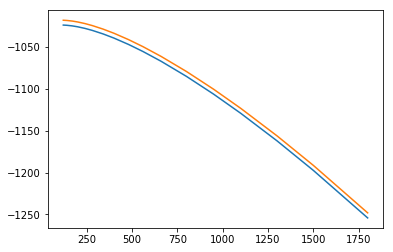

In [19]:
Gvacancy=np.zeros((len(ttnpt)-5,3))
for i in xrange(len(ttnpt)-5):
    T1=intdhvacancy[i,0]
    Gvacancy[i,0]=T1
    Gvacancy[i,1]=intdhvacancy[i,1]+U0vacancy+(T1/T0)*(GvacancyT0-U0vacancy)-nfreevacancy*kbev*T1*np.log(T1/T0)
    Gvacancy[i,2]=intdhvacancy[i,2]+(T1/T0)*GvacancyT0error
    
plt.plot(Gbcc[:,0],Gbcc[:,1])
plt.plot(Gvacancy[:,0],Gvacancy[:,1])
plt.show()

# This the free energy associated with the center of mass
### $\Delta A_{cm}(N, V, T)=-k_B T\left(\ln\dfrac{V}{N \Lambda^3}+\dfrac{3}{2}\ln N\right)$
 $ \Lambda=(2\pi \hbar^2/(atomicmass\times dalton \times k_B  T))^{1/2}=17.458218 /\sqrt{T*atomicmass}~A$
### For BCC iron At 0K, $V/N=11.82 A^3$
### Now we add this to the free energy in order to retrieve the free energy of the uncontrained system

In [20]:
massfe=55.845
vdivideN=11.82
for i in xrange(len(Gbcc)):
    T1 = Gbcc[i,0]
    acm = -kbev*T1*(np.log(vdivideN/(17.458218/np.sqrt(T1*massfe))**3.)+1.5*np.log(natombcc))
    #print T1, acm
    Gbcc[i,1] += acm
print Gbcc

[[  1.20000000e+02  -1.02382681e+03   1.31052262e-03]
 [  1.40000000e+02  -1.02411143e+03   1.60194301e-03]
 [  1.70000000e+02  -1.02488888e+03   2.03190270e-03]
 [  2.00000000e+02  -1.02602172e+03   2.46265946e-03]
 [  2.40000000e+02  -1.02799614e+03   3.04160792e-03]
 [  2.80000000e+02  -1.03042119e+03   3.62632597e-03]
 [  3.40000000e+02  -1.03476807e+03   4.51327311e-03]
 [  4.00000000e+02  -1.03983400e+03   5.41074324e-03]
 [  4.80000000e+02  -1.04752520e+03   6.62158466e-03]
 [  5.60000000e+02  -1.05612537e+03   7.84690105e-03]
 [  6.60000000e+02  -1.06796266e+03   9.39747148e-03]
 [  8.00000000e+02  -1.08625804e+03   1.16018726e-02]
 [  9.50000000e+02  -1.10775596e+03   1.40061115e-02]
 [  1.10000000e+03  -1.13094514e+03   1.64545320e-02]
 [  1.30000000e+03  -1.16417236e+03   1.97916250e-02]
 [  1.50000000e+03  -1.19975236e+03   2.32145994e-02]
 [  1.80000000e+03  -1.25710818e+03   2.85360015e-02]]


In [21]:
for i in xrange(len(Gvacancy)):
    T1 = Gvacancy[i,0]
    acm = -kbev*T1*(np.log(vdivideN/(17.458218/np.sqrt(T1*massfe))**3.)+1.5*np.log(natomvacancy))
    #print T1, acm
    Gvacancy[i,1] += acm
print Gvacancy

[[  1.20000000e+02  -1.01804971e+03   1.02061257e-03]
 [  1.40000000e+02  -1.01833836e+03   1.21885366e-03]
 [  1.70000000e+02  -1.01912027e+03   1.51531517e-03]
 [  2.00000000e+02  -1.02025619e+03   1.82101566e-03]
 [  2.40000000e+02  -1.02223271e+03   2.22585349e-03]
 [  2.80000000e+02  -1.02465832e+03   2.62200701e-03]
 [  3.40000000e+02  -1.02900327e+03   3.21745585e-03]
 [  4.00000000e+02  -1.03406441e+03   3.81429447e-03]
 [  4.80000000e+02  -1.04174559e+03   4.61272166e-03]
 [  5.60000000e+02  -1.05033237e+03   5.41489735e-03]
 [  6.60000000e+02  -1.06214943e+03   6.42381314e-03]
 [  8.00000000e+02  -1.08041251e+03   7.84548863e-03]
 [  9.50000000e+02  -1.10187406e+03   9.62998208e-03]
 [  1.10000000e+03  -1.12502754e+03   1.16525341e-02]
 [  1.30000000e+03  -1.15821201e+03   1.44170755e-02]
 [  1.50000000e+03  -1.19375500e+03   1.72758525e-02]
 [  1.80000000e+03  -1.25106036e+03   2.17909810e-02]]


# Now compute vacancy free energy
### $G_v = G_{vacancy} - \dfrac{N_{vacancy}}{N_{bcc}} G_{bcc}$

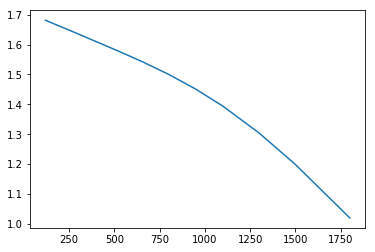

In [22]:
Gv=np.zeros((len(ttnpt)-5,3))
for i in xrange(len(ttnpt)-5):
    T1=Gvacancy[i,0]
    Gv[i,0]=T1
    Gv[i,1]=Gvacancy[i,1]-Gbcc[i,1]*natomvacancy/natombcc
    Gv[i,2]=np.sqrt(Gvacancy[i,2]**2.0+Gbcc[i,2]**2.0)
    
plt.plot(Gv[:,0],Gv[:,1])
plt.show()